In [1]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

drv = dut.drv

ser = serial.Serial('COM6',9600,timeout=1)
dut.connect(ser)

In [2]:
drv.clk_stop('ADC_CK')
drv.clk_stop('CK_ARRAY')
drv.clk_config('ADC_CK',divisor=2)
drv.clk_config('CK_ARRAY',divisor=2)
drv.clk_start('ADC_CK')
drv.clk_start('CK_ARRAY')

Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


In [3]:
dut.power_on()
dut.reset_chip()
dut.reset_dpe()

Setting vrefs to default
DAC initialized to a span from -10 V to 10 V


In [275]:
dut.disconnect()

time= -42.536258697509766


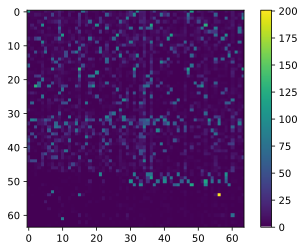

In [9]:
ar=1
numRows=64
numCols=64
vread=0.2
vgate=5
Gmap0=np.zeros((numRows,numCols))
ts=time.time()
for rr in range(numRows):
    for cc in range(numCols):
        rdCurr=a0.pic_read_single(ar,rr,cc,Vread=vread,Vgate=vgate)
        #rdCurr=a0.read_single_int(vread,vgate,array=ar,row=rr,col=cc,gain=-1)
        Gmap0[rr,cc]=rdCurr/vread

tt=time.time()-ts
print('time=',tt)
plt.imshow(Gmap0*1e6)
plt.colorbar()


In [241]:
vread=0.2
vgate=5.0
ar=0
r=0
c=8
targetG=150e-6
tolG=10e-6
vsetramp=np.arange(0.1,2.2,0.1)
vsetgate=np.arange(0.5,1.5,0.05)
vresetramp=np.arange(0.1,2.2,0.1)
vresetgate=np.arange(5.0,5.5,0.1)
#print(a0.read_single_int(vread,vgate,array=ar,row=r,col=c,gain=-1)/vread)
#print(a0.pic_read_single(ar,r,c,Vread=vread,gain=-1)/vread)
a0.cell_program(ar,r,c,targetG,tolG,vsetramp,vresetramp,vsetgate,vresetgate)

0.0001459758879113718

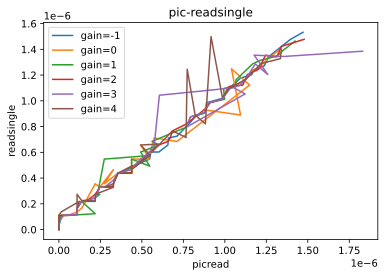

In [19]:
vreads=np.arange(0,0.35,0.01)
vgate=5.0
ar=0
r=0
c=0
gains=[-1,0,1,2,3,4]

plt.figure(2)
plt.xlabel('picread')
plt.ylabel('readsingle')
plt.title('pic-readsingle')

for g in gains:
    reads1=[]
    reads2=[]
    for vread in vreads:
        curr1=a0.pic_read_single(ar,r,c,Vread=vread,gain=-1)
        curr2=a0.read_single_int(vread,vgate,array=ar,row=r,col=c,gain=-1)
        reads1.append(curr1)
        reads2.append(curr2)

    plt.plot(reads1,reads2,'-',label='gain='+str(g))

plt.legend()    
plt.savefig('C:/Users/localuser/Documents/GitHub/A0_DUT/dataRuibin/singletest/single_test/pic-readsingle1.png',dpi=600)

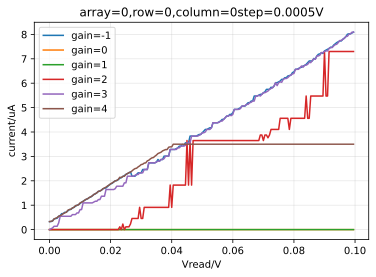

In [85]:
#path:C:/Users/localuser/Documents/GitHub/A0_DUT/dataRuibin/singletest
ar=0
r=0
c=0
vgate=5.0
ga=[-1,0,1,2,3,4]
Vreads=np.arange(0,0.1,0.0005)

volts_set=[]
for ga in gains:
    volts=[]
    for vread in Vreads:
        volts.append( a0.read_single_int(vread,vgate,array=ar,row=r,col=c,gain=ga) )
        raw_adc=a0.read_single_int
    volts_set.append(volts)

plt.figure(1)
plt.xlabel('Vread/V')
plt.ylabel('current/uA')
plt.title('array='+str(ar)+','+'row='+str(r)+','+'column='+str(c)+'step=0.0005V')
for i in range(np.shape(volts_set)[0]):
    plt.plot(Vreads,[j*1e6 for j in volts_set[i]],'-',label='gain='+str(gains[i]))
plt.legend() 
plt.grid(True, alpha=0.3)
plt.savefig('C:/Users/localuser/Documents/GitHub/A0_DUT/dataRuibin/singletest/single_test/20201207/vread_difgain_0_0.1_0.0005.png',dpi=600)


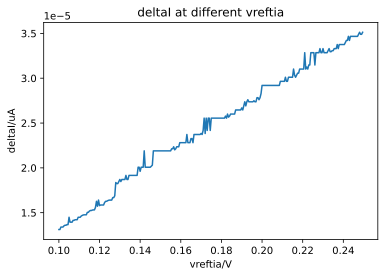

In [230]:
ar=0
r=0
c=0

Vreads=np.arange(0.1,0.25,0.0005)
Vgate=5.0

#dut.dac_set('DAC_VREF_HI_CMP',4.0)

#Vrefhicmps=np.arange(3.98,4.13,0.01)
Vrefhicmps=[4.0]
deltaIs=[]
#Vrefs=np.arange(0.7,0.9,0.01)
Vrefs=[0.5]
dut.dac_set('DAC_VREF_HI_CMP',4.11)

plt.figure(1)
plt.xlabel('vreftia/V')
plt.ylabel('deltaI/uA')
plt.title('deltaI at different vreftia')

for vref in Vrefs:
#for vrefhicmp in Vrefhicmps:
    #dut.dac_set('DAC_VREF_HI_CMP',vrefhicmp)
    volts=[]
    for vread in Vreads:
        raw_adc=a0.read_single_int(vread,Vgate,array=ar,row=r,col=c,Vref=0.5,gain=-1,raw=True)
        volts.append(a0.adc2current(raw_adc,vref))
        #volts.append(a0.read_single_int(vread,Vgate,array=ar,row=r,col=c,Vref=0.5,gain=-1))
        #volts.append(a0.pic_read_single(ar,r,c,Vread=vread,gain=-1))
    
    plt.plot(Vreads,volts,'-')
    #plt.plot(Vreads,[i*1e6 for i in volts],'-',linewidth=1,label='vrefhicmp='+str(round(vrefhicmp,2)))
    p3=np.polyfit(Vreads,volts,1)
    #print(p3)
    deltaIs.append(p3[1])

#plt.plot(Vrefs,[i*1e6 for i in deltaIs],'-')
#plt.savefig('C:/Users/localuser/Documents/GitHub/A0_DUT/dataRuibin/singletest/single_test/20201207/vread_difvrefcal_0.7_0.9_0.01_gain4.png',dpi=600)
#print(min([abs(i) for i in deltaIs]))
#minindex=[abs(i) for i in deltaIs].index(min([abs(i) for i in deltaIs]))
#print(Vrefs[minindex])

#f=open('C:/Users/localuser/Documents/GitHub/A0_DUT/dataRuibin/singletest/single_test/20201207/vread_difvrefcal_0.3_0.4_0.001.txt',mode='a')
#print(str(Vrefs[minindex]),file=f)
#print(str(deltaIs[minindex]),file=f)
#f.close()

#plt.legend(fontsize='x-small')
#plt.savefig('C:/Users/localuser/Documents/GitHub/A0_DUT/dataRuibin/singletest/single_test/20201207/vread_difvrefhicmp_4.11.png',dpi=600)

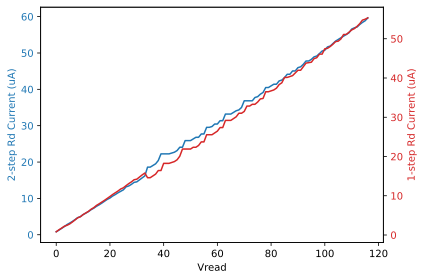

In [223]:
ar=0
r=0
c=1


def read_single_int_corr(Vread,Vgate,array=0,row=0,col=0,gain=0,Tsh=-1,Vref=0.5,raw=False):
    #Vrefs=[0.5,0.5,0.614,0.592,0.300]
    Vrefs=[0.5,0.5,0.38,0.433,0.5]
    #Vrefs=[0.5,0.5,0.5,0.5,0.5]
    
    raw_adc=a0.read_single_int(Vread,Vgate,array=array,row=row,col=col,gain=gain,Tsh=-1,Vref=Vref,raw=True)
    g=raw_adc>>10
    if raw:
        return raw_adc
        #return a0.read_single_int(Vread,Vgate,array=array,row=row,col=col,gain=gain,Tsh=-1,Vref=Vrefs[g],raw=True)
    else:
        return a0.adc2current(raw_adc,Vrefs[g])
        #return a0.read_single_int(Vread,Vgate,array=array,row=row,col=col,gain=gain,Tsh=-1,Vref=Vrefs[g],raw=False)

Vreads=np.arange(0,0.35,0.003)
Vgate=5.0
#plt.figure(1)
#plt.xlabel('vreads/V')
#plt.ylabel('readI/uA')
#plt.title('readI-V')
rdcurrs1=[]
rdcurrs=[]

for vread in Vreads:
    rdcurrs1.append(read_single_int_corr(vread,Vgate,ar,r,c,gain=-1))
    rdcurrs.append(a0.read_single_int(vread,Vgate,array=ar,row=r,col=c,gain=-1,Tsh=-1))
    
#plt.plot(Vreads,[i*1e6 for i in volts],'-')

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('2-step Rd Current (uA)', color=color)
ax1.plot([i* 1e6 for i in rdcurrs1], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('1-step Rd Current (uA)', color=color)
ax2.plot([i* 1e6 for i in rdcurrs], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

#plt.savefig('C:/Users/localuser/Documents/GitHub/A0_DUT/dataRuibin/singletest/single_test/20201207/vread_i_Vrefcalcorr_0_0.35_0.001.png',dpi=600)

[5.46218546e-05 1.40128609e-07]


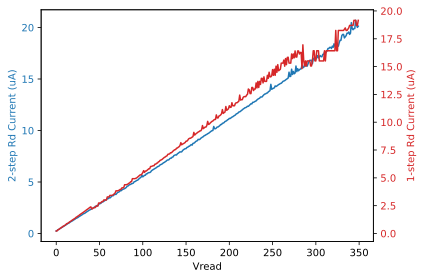

In [274]:
ar=0
r=1
c=0

#VADC_boundary = np.array([0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6, 4.1])
#VRefHiCmp = np.array([5.7, 5.3, 4.9, 4.5, 4.1, 3.7, 3.3, 2.4, 2.0])
_gain_ratio = [1e3, 5e3, 30e3, 200e3, 1e6]
vOffset = 0
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vreads = np.arange(0, 0.35, 0.001)
# vRead = 0.2
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrs1 = []
volts=[]
    
for vRead in Vreads:
    #Vreftias=[0.5,0.5,0.614,0.592,0.300]
    #Vrefs=[0.5,0.5,0.55,0.433,0.5]
    Vrefs=[0.5,0.5,0.5,0.5,0.5]
    adc_raw = a0.read_single_int(vRead, Vgate, array=ar, row=r, col=c, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    volts.append(VADC_read_first)
    gainFirst = adc_raw >> 10
    rdCurr1 = (VADC_read_first - Vrefs[gainFirst]) / _gain_ratio[gainFirst]
    #secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    #secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    secondVRefHiCmp=4.0+(2.25-VADC_read_first)
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=ar, row=r, col=c, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - (4.0)) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - Vrefs[gainFirst]) / _gain_ratio[gainFirst]
    rdCurrs.append(rdCurr)
    rdCurrs1.append(rdCurr1)    


fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('2-step Rd Current (uA)', color=color)
ax1.plot([i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('1-step Rd Current (uA)', color=color)
ax2.plot([i* 1e6 for i in rdCurrs1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.savefig('C:/Users/localuser/Documents/GitHub/A0_DUT/dataRuibin/singletest/single_test/20201207/vread_i_Vrefcalcorr_'+'column'+str(c)+'row'+str(r)+'.png',dpi=600)

p1=np.polyfit(Vreads,rdCurrs1,1)
print(p1)

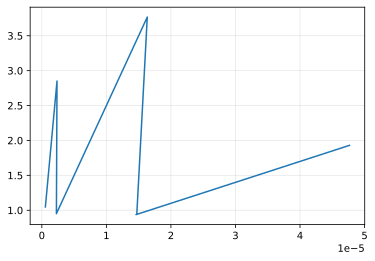

In [260]:
ar=0
r=0
c=0

Vreads=np.arange(0,0.35,0.001)

dcurrs=[]
dvolts=[]

for vread in Vreads:
    raw_adc=a0.read_single_int(vread, Vgate, array=ar, row=r, col=c, gain=-1, raw=True)
    dcurrs.append(a0.adc2current(raw_adc,0.5))
    dvolts.append(dut.adc2volt(raw_adc))
    
plt.plot(dcurrs,dvolts,'-')
plt.grid(True,alpha=0.3)